## Проект: Удовлетворенность сотрудников

Цели:
1) построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2) построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Описание входных данных:
id — уникальный идентификатор сотрудника;
dept — отдел, в котором работает сотрудник;
level — уровень занимаемой должности;
workload — уровень загруженности сотрудника;
employment_years — длительность работы в компании (в годах);
last_year_promo — показывает, было ли повышение за последний год;
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
salary — ежемесячная зарплата сотрудника;
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
quit - маркер уволен сотрудник или нет

### Загрузка и предобработка данных

In [1]:
# загрузим необходимые библиотеки
!pip install pandas
import pandas as pd
!pip install scikit-learn==1.1.3 -q
!pip install --upgrade shap -q
import shap
from sklearn.model_selection import train_test_split
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install phik seaborn -q

from pandas.plotting import scatter_matrix
import seaborn as sns
from phik import phik_matrix
import numpy as np

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler, Normalizer, FunctionTransformer
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error


# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

# изменим формат представления чисел с плавающей точкой
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
train_df=pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

In [3]:
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
X_test=pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
y_test=pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
y_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [9]:
# посмотрим есть ли дубликаты и удалим их
print(train_df.duplicated().sum())
print(X_test.duplicated().sum())
print(y_test.duplicated().sum())

0
0
0


In [10]:
# Дубликатов нет, посмотрим есть ли неявные дубликаты в категориальных признаках
cat_col=X_test.select_dtypes(include=['object']).columns.tolist()
# заодно сразу обозначим количественные признаки
num_col=X_test.select_dtypes(include=['number']).columns.tolist()
cat_col

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [11]:
train_df[cat_col].apply(lambda x: x.value_counts())

,dept,level,workload,last_year_promo,last_year_violations
high,NaN,NaN,734.00,NaN,NaN
hr,456.00,NaN,NaN,NaN,NaN
junior,NaN,"1,894.00",NaN,NaN,NaN
low,NaN,NaN,"1,200.00",NaN,NaN
marketing,550.00,NaN,NaN,NaN,NaN
medium,NaN,NaN,"2,066.00",NaN,NaN
middle,NaN,"1,744.00",NaN,NaN,NaN
no,NaN,NaN,NaN,"3,880.00","3,441.00"
purchasing,610.00,NaN,NaN,NaN,NaN
sales,"1,512.00",NaN,NaN,NaN,NaN


In [12]:
X_test[cat_col].apply(lambda x: x.value_counts())

,dept,level,workload,last_year_promo,last_year_violations
,1.00,NaN,1.00,NaN,NaN
high,NaN,NaN,363.00,NaN,NaN
hr,227.00,NaN,NaN,NaN,NaN
junior,NaN,974.00,NaN,NaN,NaN
low,NaN,NaN,593.00,NaN,NaN
marketing,279.00,NaN,NaN,NaN,NaN
medium,NaN,NaN,"1,043.00",NaN,NaN
middle,NaN,854.00,NaN,NaN,NaN
no,NaN,NaN,NaN,"1,937.00","1,738.00"
purchasing,273.00,NaN,NaN,NaN,NaN


In [13]:
# выведем пропуски
train_df[train_df.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [14]:
# выведем пропуски
X_test[X_test.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [15]:
# сделаем id индексом
train_df=train_df.set_index('id')
X_test=X_test.set_index('id')
y_test=y_test.set_index('id')

In [16]:
merged=X_test.merge(y_test,left_index=True, right_index=True)
y_test=merged['job_satisfaction_rate']
X_test=merged.drop('job_satisfaction_rate',axis=1)

Выборка состоит из данных о 4000 клиентов в тренирововчной выборке и 2000 клиентов в тестовой выборке, всего 10 признаков.Неявных и явных дубликатов в данных не обнаружено. Типы данных правильные. 
В датасете есть пропуски в признаках dept и level, их мы заполним после анализа. 
Перейдем к исследовательскому анализу данных.

## Задача №1: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

### Исследовательский анализ данных

In [17]:
# создадим функцию для визуализации данных
def visualize_dataframe_columns(dataframe):
    for column in dataframe.columns:
        if column=='id':
            continue
        column_data = dataframe[column]
        
        # Determine plot type based on data type
        plot_type = 'bar' if pd.api.types.is_string_dtype(column_data) else 'both'

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if plot_type=='bar':
            axes[0].set_title(f'Bar - {column}')
            axes[0].set_xticks(range(len(column_data.unique())))
            axes[0].set_xticklabels(column_data.unique(), rotation=90, ha='right')
            axes[0].bar(x=column_data.unique(), color='yellow', edgecolor='black', height=column_data.value_counts())
            
        else:
            axes[0].set_title(f'Histogram - {column}')
            axes[0].hist(column_data, bins=20, color='skyblue', edgecolor='black')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')

        # Plot boxplot (if not a string column)
        if plot_type == 'both':
            axes[1].set_title(f'Boxplot - {column}')
            axes[1].boxplot(column_data, vert=False)
            axes[1].set_xlabel(column)

        plt.tight_layout()
        plt.show()

In [18]:
# создадим функцию для сравнения данных
def visualize_columns_comparison(dataframe):
    df_0=dataframe[dataframe['job_satisfaction_rate']<0.56]
    df_1=dataframe[dataframe['job_satisfaction_rate']>=0.56]
    len_0=len(dataframe[dataframe['job_satisfaction_rate']<0.56])
    len_1=len(dataframe[dataframe['job_satisfaction_rate']>=0.56])
    for column in dataframe.columns:
        if column=='id':
            continue
        column_data_0 = df_0[column]
        column_data_1 = df_1[column]
        # Determine plot type based on data type
        plot_type = 'bar' if pd.api.types.is_string_dtype(column_data_0) else 'both'

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if plot_type=='bar':
            axes[0].set_title(f'Bar - {column} уровень удовлетв. <0.56 ({len_0} чел)')
            axes[0].set_xticks(range(len(column_data_0.unique())))
            axes[0].set_xticklabels(column_data_0.unique(), rotation=90, ha='right')
            axes[0].bar(x=column_data_0.unique(), color='yellow', edgecolor='black', height=column_data_0.value_counts())
                
            axes[1].set_title(f'Bar - {column} уровень удовлетв. >=0.56 ({len_1} чел)')
            axes[1].set_xticks(range(len(column_data_1.unique())))
            axes[1].set_xticklabels(column_data_1.unique(), rotation=90, ha='right')
            axes[1].bar(x=column_data_1.unique(), color='yellow', edgecolor='black', height=column_data_1.value_counts())

        else:
            axes[0].set_title(f'Histogram - {column} уровень удовлетв. <0.56 ({len_0} чел)')
            axes[0].hist(column_data_0, bins=20, color='skyblue', edgecolor='black')
                
            axes[1].set_title(f'Histogram - {column} уровень удовлетв. >=0.56 ({len_1} чел)')
            axes[1].hist(column_data_1, bins=20, color='skyblue', edgecolor='black')
                
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

In [19]:
train_df.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"4,000.00","4,000.00","4,000.00","4,000.00"
mean,3.72,3.48,"33,926.70",0.53
std,2.54,1.01,"14,900.70",0.23
min,1.00,1.00,"12,000.00",0.03
25%,2.00,3.00,"22,800.00",0.36
50%,3.00,4.00,"30,000.00",0.56
75%,6.00,4.00,"43,200.00",0.71
max,10.00,5.00,"98,400.00",1.00


Медиана удовлетворенности работой находится на уровне 0,56. Используем это значение для разделения выборки на 2 категории: <0,56 - низкий уровень удовлетворенности работой, >=0,56 - высокий уровень удовлетворенности работой. Сравним полученные выборки на графиках.

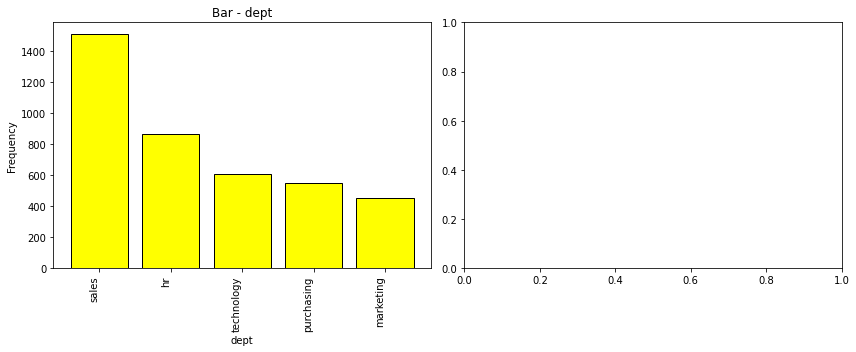

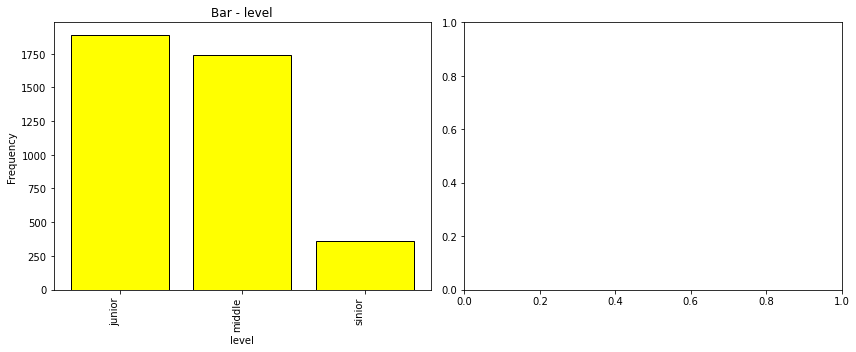

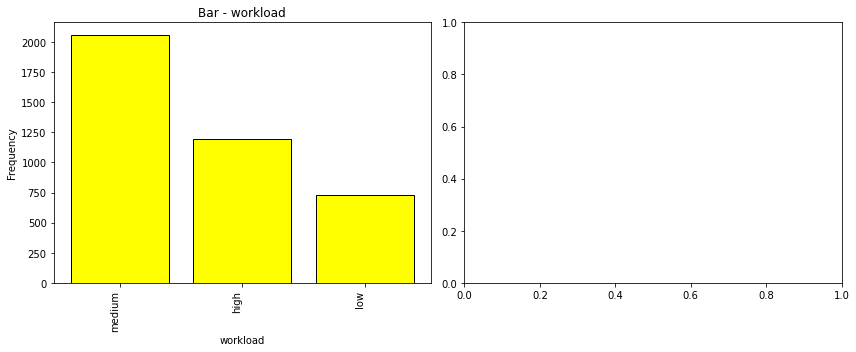

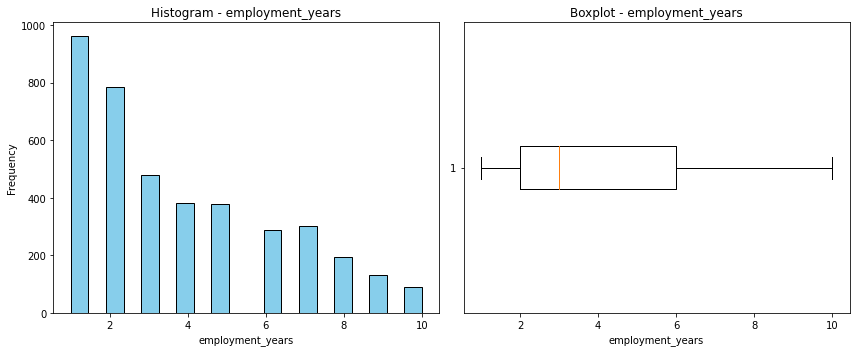

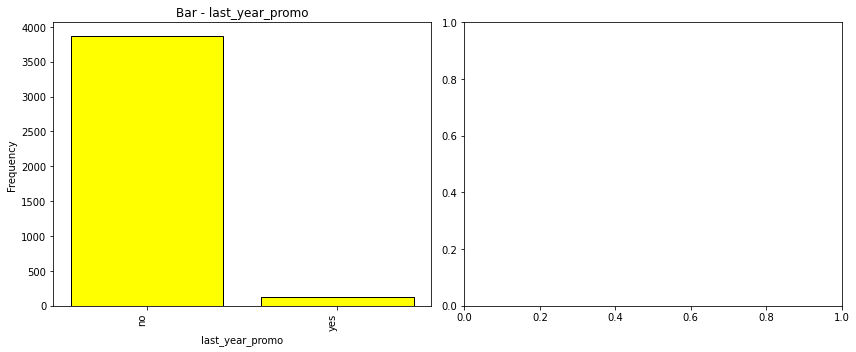

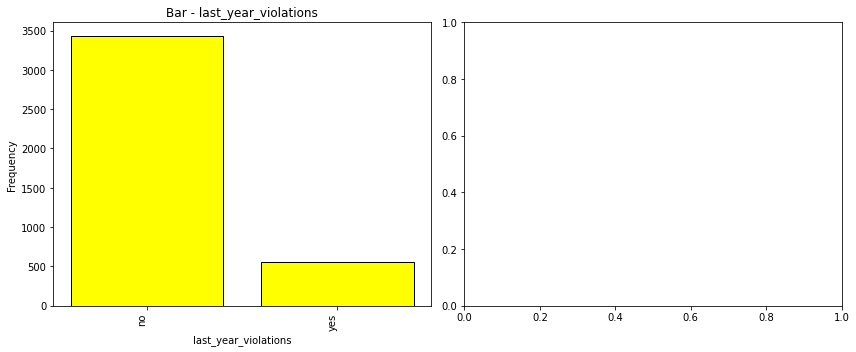

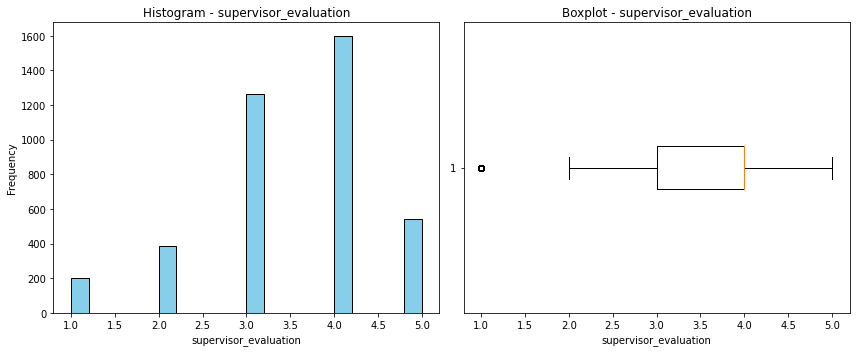

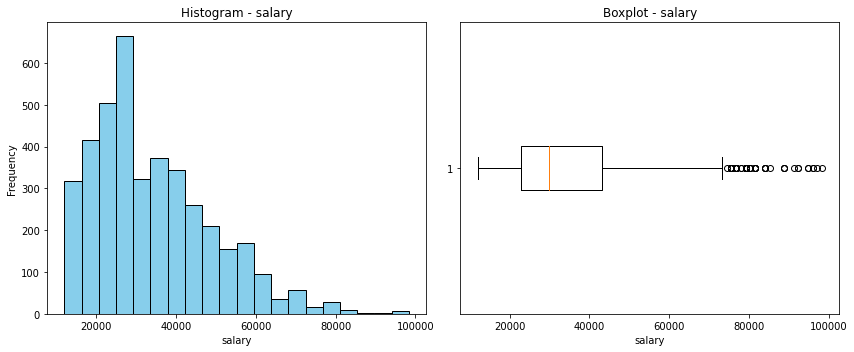

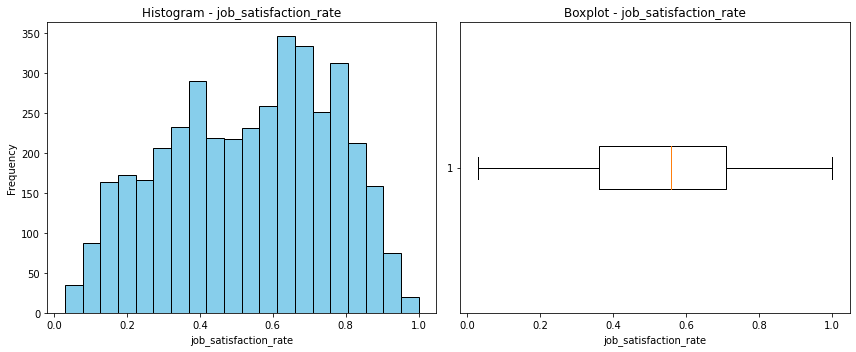

In [20]:
visualize_dataframe_columns(train_df[train_df.notna().all(axis=1)])

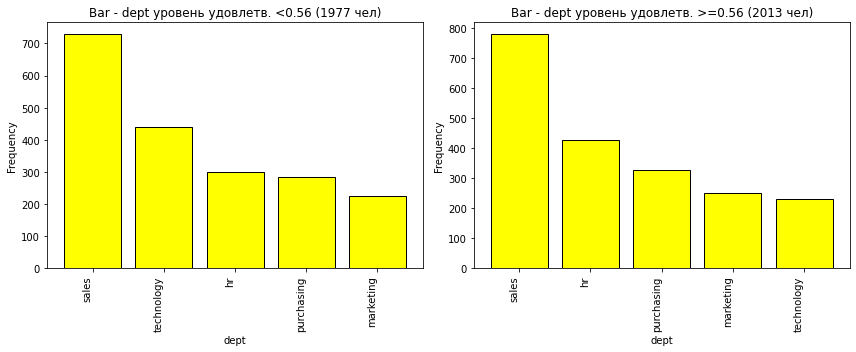

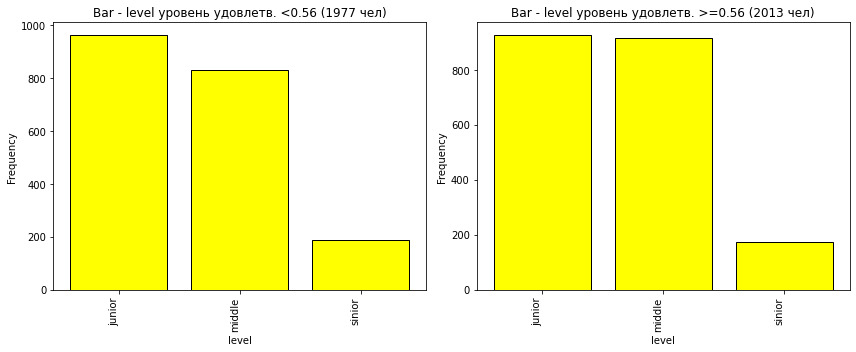

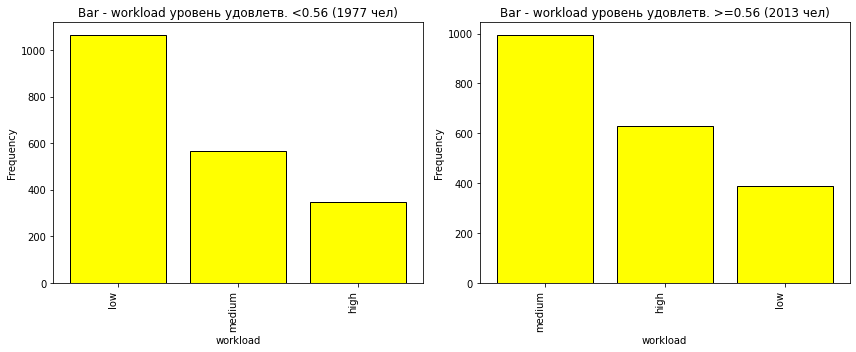

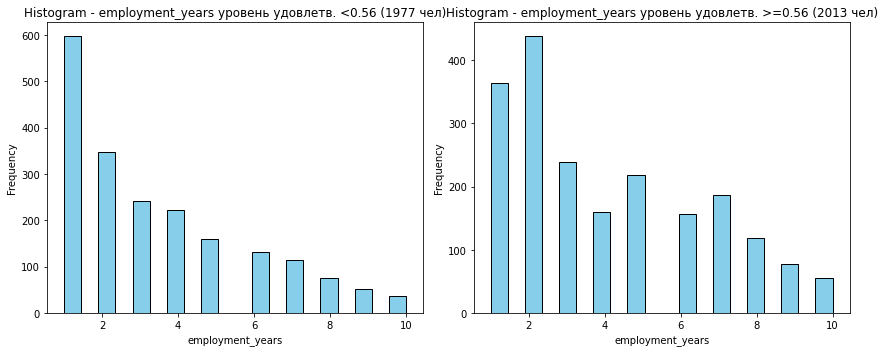

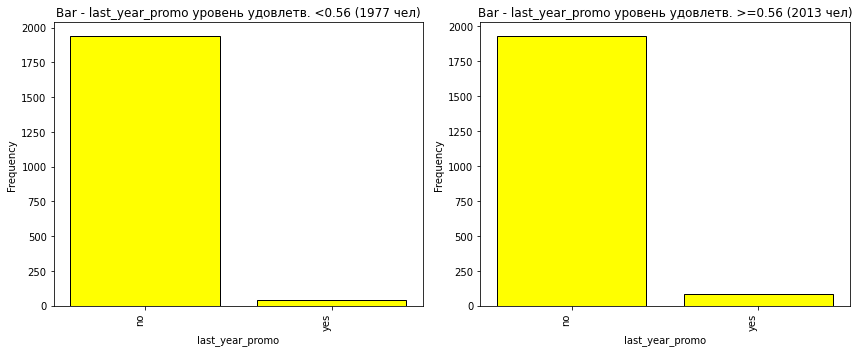

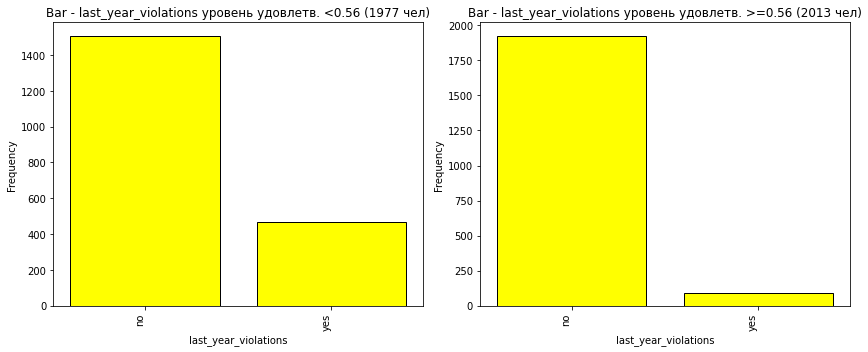

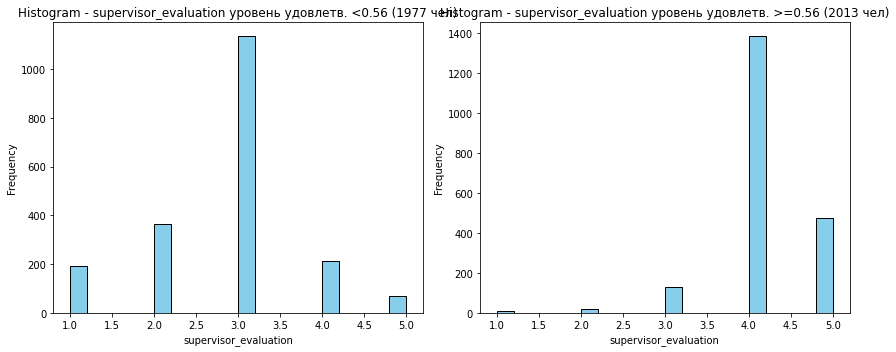

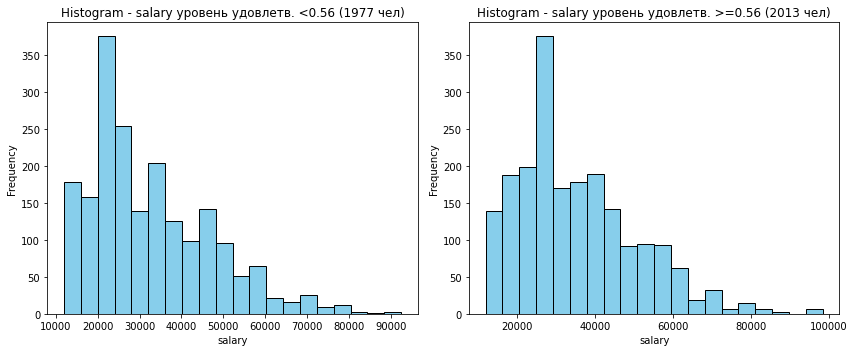

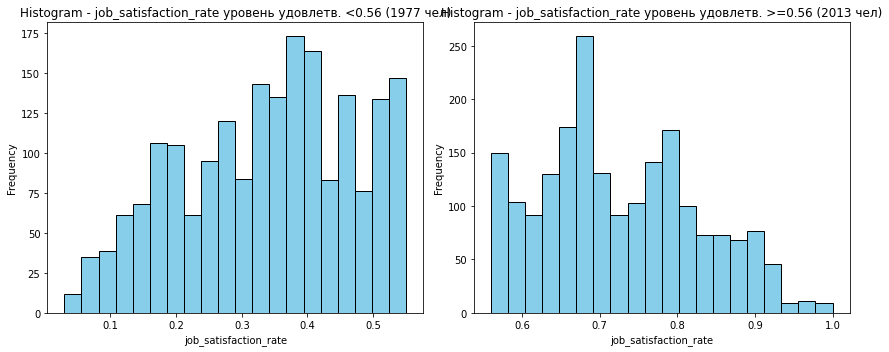

In [21]:
visualize_columns_comparison(train_df[train_df.notna().all(axis=1)])

В результате сравнения можно сделать следующие выводы:
1) Отдел продаж sales самый большой отдел и она занимает первые места и в выборке со сниженной удовлетворенностью работой и с повышенной. На втором месте по удовлетворенности идет технологический отдел(есть подозрения, что в этом отделе зарплата выше среднего), на втором месте по неудовлетворенности идет hr. 
2) Junior наибольшая группа в выборке, на втором месте middle. 
3) Доля middle в выборке с повышенной удовлетворенностью явно выше, чем в пониженной. 
4) Сотрудники с низкой загрузкой чаще недовольны работой, чем более загруженные сотрудники. 
5) Новенькие сотрудники склонные ставить более низкие оценки. 
6) Зарплата у недовольных сотрудников явно ниже в среднем, чем у довольных. как и оценка от руководителя.
Единица измерения у признаков очень разнородная, поэтому необьходимо произвести масштабирование, а категориальные признаки закодировать. Пропущенных значений очень мало, поэтому заменим их на медиану и моду.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


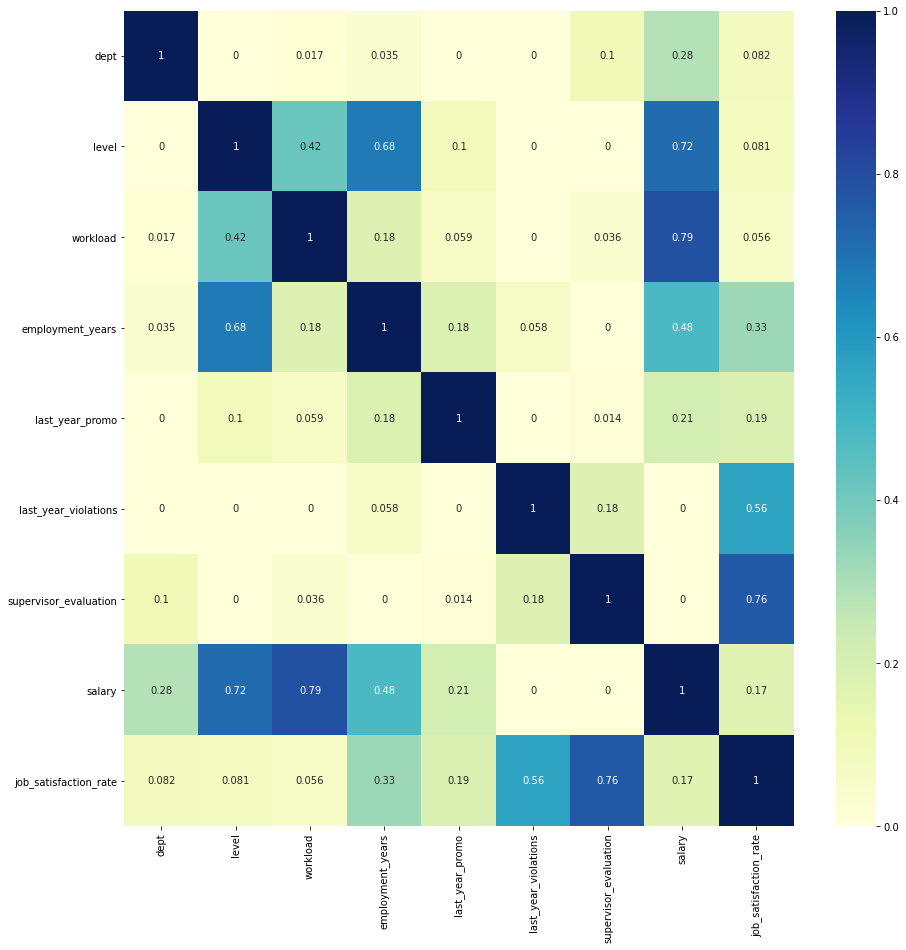

In [22]:
# Построим матрицу корреляции Phik для количественных и качественных признаков
phik_corr_matrix = phik_matrix(train_df[train_df.notna().all(axis=1)])
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

Мультиколлинеарности между признаками не обнаружено. Целевой признак job_satisfaction_rate имеет видимую связь с supervisor_evaluation, last_year_violations, employment_years

### Подготовка данных


In [23]:
y_train=train_df['job_satisfaction_rate']
X_train=train_df.drop('job_satisfaction_rate',axis=1)

In [24]:
display(y_train)
X_train

id
155278   0.58
653870   0.76
184592   0.11
171431   0.37
693419   0.20
         ... 
457950   0.45
957499   0.68
533318   0.76
706868   0.48
338347   0.18
Name: job_satisfaction_rate, Length: 4000, dtype: float64

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800
...,...,...,...,...,...,...,...,...
457950,technology,junior,high,2,no,no,3,46800
957499,sales,junior,medium,2,no,no,4,21600
533318,sales,middle,low,7,no,no,5,24000


In [25]:
# Напишем функцию для вычисления новой метрики качества SMAPE - симметричное среднее абсолютное процентное отклонение
def calculate_smape(y_true, y_pred):
   return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

score_smape=make_scorer(calculate_smape, greater_is_better=False )
score_r2=make_scorer(r2_score, greater_is_better=True)
score_mae=make_scorer(mean_absolute_error, greater_is_better=False)
score_mse=make_scorer(mean_squared_error, greater_is_better=False)

In [26]:
# создаём списки с названиями признаков
ohe_columns = [ 'dept', 'last_year_promo', 'last_year_violations' ]
ord_columns = ['level', 'workload', ]
num_columns = ['employment_years','supervisor_evaluation', 'salary' ]
RANDOM_STATE = 42

In [27]:
# Создадим пайплайн с заполнением пропусков, масштабированием, кодированием и моделированием

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [  
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer 
ord_pipe = Pipeline(
    [   (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
                            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
# Создадим функцию для log transformation. Это должно помочь снижать влияние аномалий и сделать связи между признаками более линейными.
def log_transform(x):
    return np.log1p(x)  # Use np.log1p to avoid issues with log(0)
# cоздаём пайплайн для подготовки количественных признаков
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
#    ('log_transform', FunctionTransformer(log_transform)),
 #   ('poly', PolynomialFeatures(degree=4)),
    ('scaler', 'passthrough')  # 'passthrough' означает, что масштабировщик будет выбран позже
])

In [28]:
# Объединяем кодирование и масштабирование в один пайплан
preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
) 

In [29]:
# Создадим итоговый пайплайн c моделью LinearRegression
pipe_final_linear = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', LinearRegression())
    ]
)
# Подбор гиперпараметров для множественной линейной модели
param_grid_linear = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()]
}

linear_pipeline_cv = GridSearchCV(pipe_final_linear, param_grid_linear, scoring=score_smape, cv=4, n_jobs=-1)

linear_pipeline_cv.fit(X_train, y_train)
y_pred = linear_pipeline_cv.predict(X_test)

best_model=linear_pipeline_cv.best_estimator_
best_params=linear_pipeline_cv.best_params_

print('Лучшие модель и гиперпараметры:\n\n', best_params)
print ('Метрика smape лучшей модели на тренировочной выборке:', linear_pipeline_cv.best_score_)
print('Метрика mse:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=4, scoring=score_mse).mean() )
print('Метрика mae:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=4, scoring=score_mae).mean() )
print('Метрика r2:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=4, scoring=score_r2).mean() )



Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Лучшие модель и гиперпараметры:

 {'preprocessor__num': MinMaxScaler()}
Метрика smape лучшей модели на тренировочной выборке: -25.042268806428126
Метрика mse: -0.01598925990147783
Метрика mae: -0.1031727898792521
Метрика r2: 0.6846613070600084


Качество моедли оставляет желать лучшего. У нас получились отрицательные числа из-зха того, что cross_val_score работает по схеме - чем больше-тем лучше, поэтому с помощью make_scorer мы сделали метрики с минусом, чтобы получать корректный результат.

In [30]:
# Создадим итоговый пайплайн с моделью DecisionTreeRegressor
pipe_final_decision = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', DecisionTreeRegressor(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE))
    ]
)
# словарь с гиперпараметрами
param_grid = [{
        'models__max_depth': range(6,10),
        'models__min_samples_split': range(2,7),
        'models__min_samples_leaf': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()]  }
    
]

grid_search = GridSearchCV(
    pipe_final_decision, 
    param_grid, 
    cv=5,
    scoring=score_smape,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_
best_params=grid_search.best_params_

# обучим лучшую модель
best_model.fit(X_train, y_train)

print('Лучшие модель и гиперпараметры:\n\n', best_params)
print ('Метрика smape лучшей модели на тренировочной выборке:', grid_search.best_score_)
print('Метрика mse на тренировочной выборке:', cross_val_score(grid_search, X_train, y_train, cv=5, scoring=score_mse).mean() )
print('Метрика mae на тренировочной выборке:', cross_val_score(grid_search, X_train, y_train, cv=5, scoring=score_mae).mean() )
print('Метрика r2 на тренировочной выборке:', cross_val_score(grid_search, X_train, y_train, cv=5, scoring=score_r2).mean() )



Лучшие модель и гиперпараметры:

 {'models__max_depth': 9, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': RobustScaler()}
Метрика smape лучшей модели на тренировочной выборке: -15.861878382790412
Метрика mse на тренировочной выборке: -0.0074321469284650155
Метрика mae на тренировочной выборке: -0.06610312300517726
Метрика r2 на тренировочной выборке: 0.8533151907375846


In [31]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred=best_model.predict(X_test)

print('Метрика smape на тестовой выборке:', calculate_smape(y_test, y_pred))
print('Метрика mse на тестовой выборке:', mean_squared_error(y_test, y_pred))
print('Метрика mae на тестовой выборке:',mean_absolute_error(y_test, y_pred))
print('Метрика r2 на тестовой выборке:',r2_score(y_test, y_pred))
y_pred=pd.DataFrame(y_pred, index=y_test.index, columns=['job_satisfaction_rate'])

Метрика smape на тестовой выборке: 15.164259888476805
Метрика mse на тестовой выборке: 0.007237840507205546
Метрика mae на тестовой выборке: 0.06553294532383852
Метрика r2 на тестовой выборке: 0.8505319929502588


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


В итоге лучшие результаты показала модель DecisionTreeRegressor с параметрами {'models__max_depth': 9, 'models__min_samples_leaf': 3, 'models__min_samples_split': 6, 'preprocessor__num': RobustScaler()}. Для улучшения результатов была предпринята попытка применить полиномизаци и лог трансформацию, но это не оказало положительных результатов. Качество модели было улучшено за счет подбора лучших параметров.

## Задача №2: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [32]:
# загрузим необходимые данные
train_df=pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [33]:
train_df=train_df.set_index('id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [34]:
X_test=pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [35]:
X_test=X_test.set_index('id')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [36]:
y_test=pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
y_test.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [37]:
y_test=y_test.set_index('id')
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


Выборка состоит из данных о 4000 клиентов в тренирововчной выборке и 2000 клиентов в тестовой выборке, всего 9 признаков. Добавился новый признак: quit - отметка уволился или остался сотрудник в компании. Это целевой признак во второй задаче. Неявных и явных дубликатов в данных не обнаружено. Типы данных правильные. 
В датасете есть пропуски в признаках dept и level, их мы заполним после анализа. 
Перейдем к исследовательскому анализу данных.

### Исследовательский анализ данных

In [38]:
# создадим функцию для сравнения данных
def visualize_columns_comparison(dataframe):
    df_0=dataframe[dataframe['quit']=='no']
    df_1=dataframe[dataframe['quit']=='yes']
    len_0=len(dataframe[dataframe['quit']=='no'])
    len_1=len(dataframe[dataframe['quit']=='yes'])
    for column in dataframe.columns:
        if column=='id':
            continue
        column_data_0 = df_0[column]
        column_data_1 = df_1[column]
        # Determine plot type based on data type
        plot_type = 'bar' if pd.api.types.is_string_dtype(column_data_0) else 'both'

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if plot_type=='bar':
            axes[0].set_title(f'Bar - {column} остались в компании ({len_0} чел)')
            axes[0].set_xticks(range(len(column_data_0.unique())))
            axes[0].set_xticklabels(column_data_0.unique(), rotation=90, ha='right')
            axes[0].bar(x=column_data_0.unique(), color='yellow', edgecolor='black', height=column_data_0.value_counts())
                
            axes[1].set_title(f'Bar - {column} уволились ({len_1} чел)')
            axes[1].set_xticks(range(len(column_data_1.unique())))
            axes[1].set_xticklabels(column_data_1.unique(), rotation=90, ha='right')
            axes[1].bar(x=column_data_1.unique(), color='yellow', edgecolor='black', height=column_data_1.value_counts())

        else:
            axes[0].set_title(f'Histogram - {column} остались в компании ({len_0} чел)')
            axes[0].hist(column_data_0, bins=20, color='skyblue', edgecolor='black')
                
            axes[1].set_title(f'Histogram - {column} уволились ({len_1} чел)')
            axes[1].hist(column_data_1, bins=20, color='skyblue', edgecolor='black')
                
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

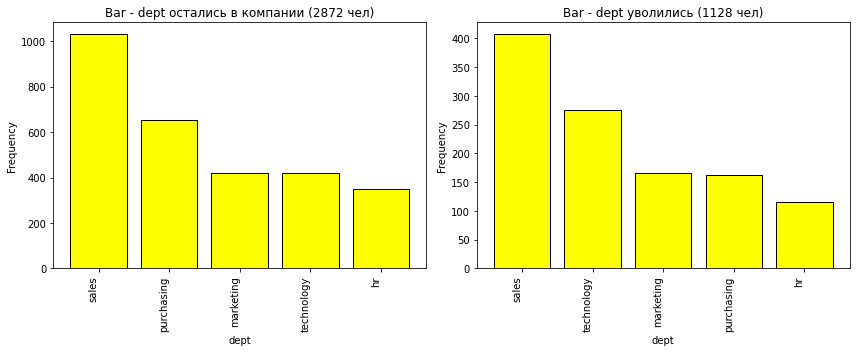

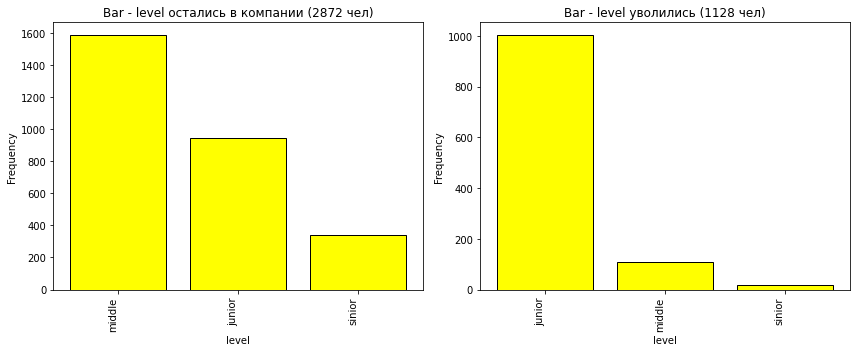

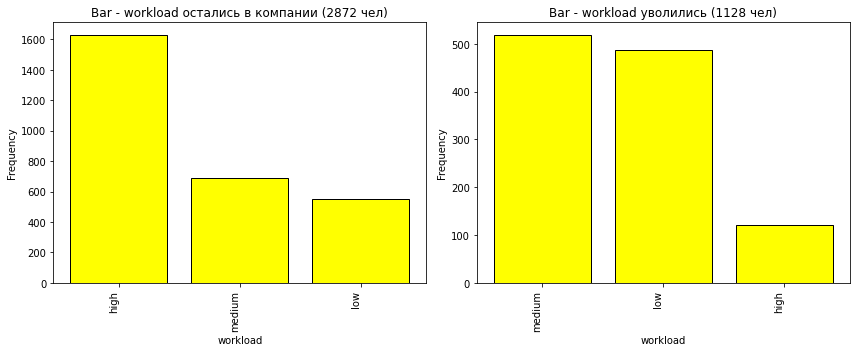

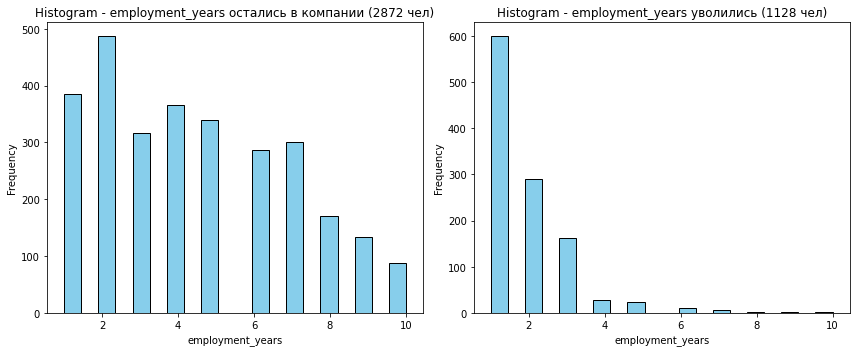

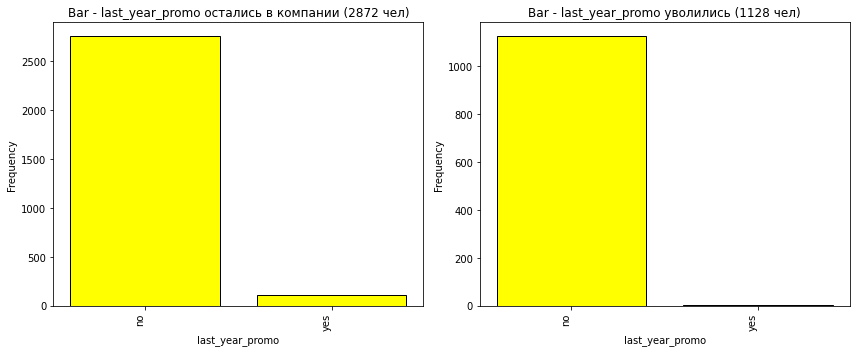

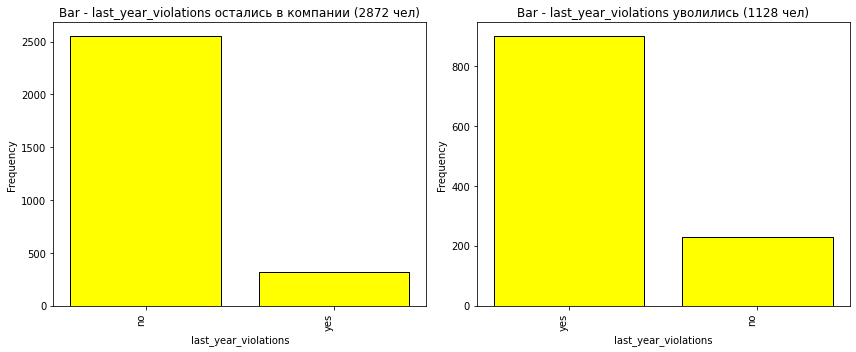

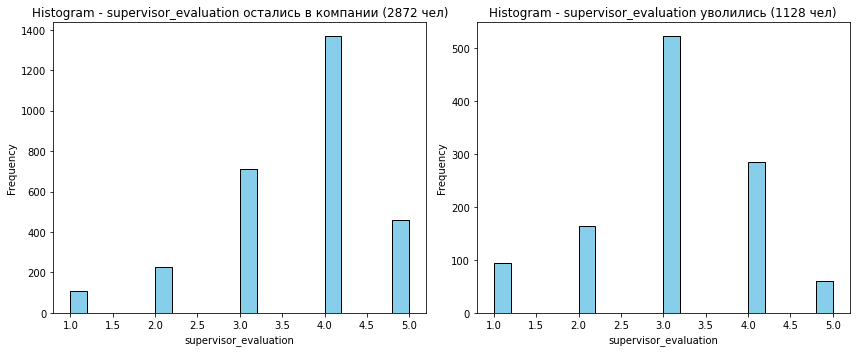

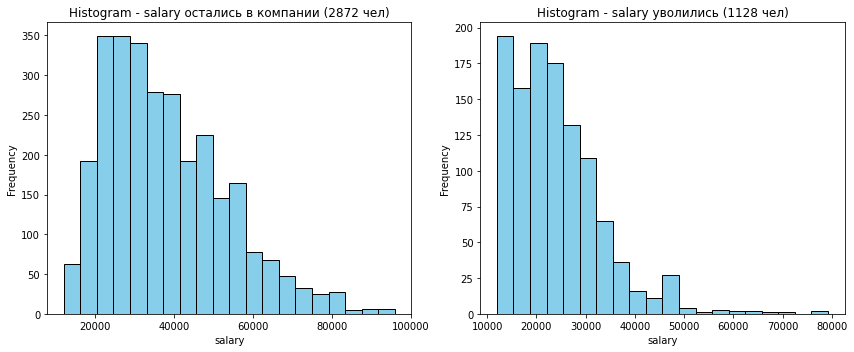

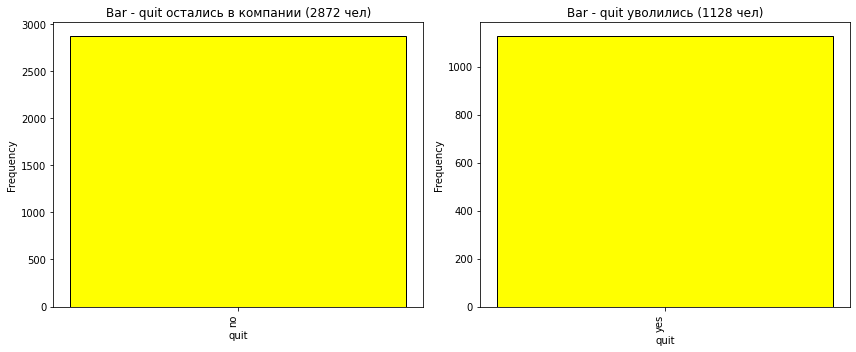

In [39]:
visualize_columns_comparison(train_df)

In [40]:
train_df['quit'].value_counts(normalize=True)

no    0.72
yes   0.28
Name: quit, dtype: float64

Уволившихся сотрудников меньшинство и составляет около 30% в выборке.
Портрет уволившегося сотрудника:
- Вероятно он из отдело продаж или технологического
- Вероятно он junior
- Вероятно загрузка у него была либо средняя или низкая
- Вероятно он совсем недолго проработал в компании
- В прошлом году у него явно не было повышения
- В прошлом году за ним явно числятся нарушения
- Он имеет среднюю оценку от руководителя
- Зарплата в среднем до 30 000

In [41]:
# добавлю признак job_satisfaction_rate

merged=X_test.merge(y_pred,left_index=True, right_index=True)
merged=merged.merge(y_test,left_index=True, right_index=True)
merged

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.83,no
686555,hr,junior,medium,1,no,no,4,30000,0.64,no
467458,sales,middle,low,5,no,no,4,19200,0.68,no
418655,sales,middle,low,6,no,no,4,19200,0.68,no
789145,hr,middle,medium,5,no,no,5,40800,0.79,no
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.50,yes
109582,technology,middle,low,3,no,no,2,21600,0.17,yes
305653,technology,junior,low,1,no,no,3,14400,0.17,yes


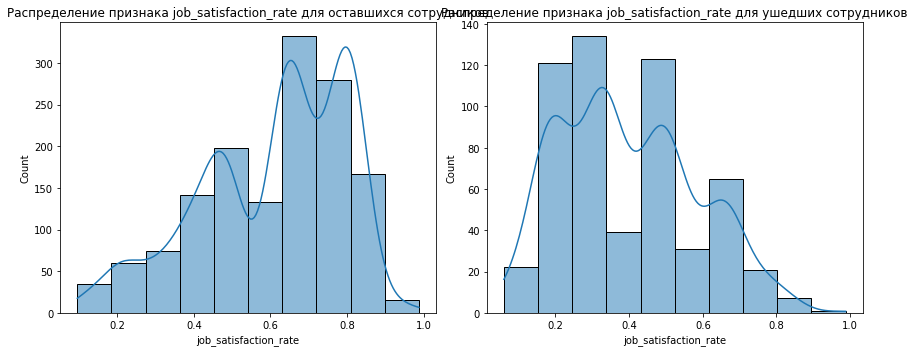

In [42]:
# а теперь изучим распределение признака job_satisfaction_rate для оставшихся и уволившихся сотрудников
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram
sns.histplot(merged[merged['quit']=='no']['job_satisfaction_rate'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Распределение признака job_satisfaction_rate для оставшихся сотрудников')

# Plot the second histogram
sns.histplot(merged[merged['quit']=='yes']['job_satisfaction_rate'], bins=10, kde=True, ax=axes[1])
axes[1].set_title('Распределение признака job_satisfaction_rate для ушедших сотрудников')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Как и ожидалось видна зависимость двух целевых признаков: для оставшихся сотрудников признак удовлетворенности работой значительно выше в среднем, чем для ушедших сотрудников.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


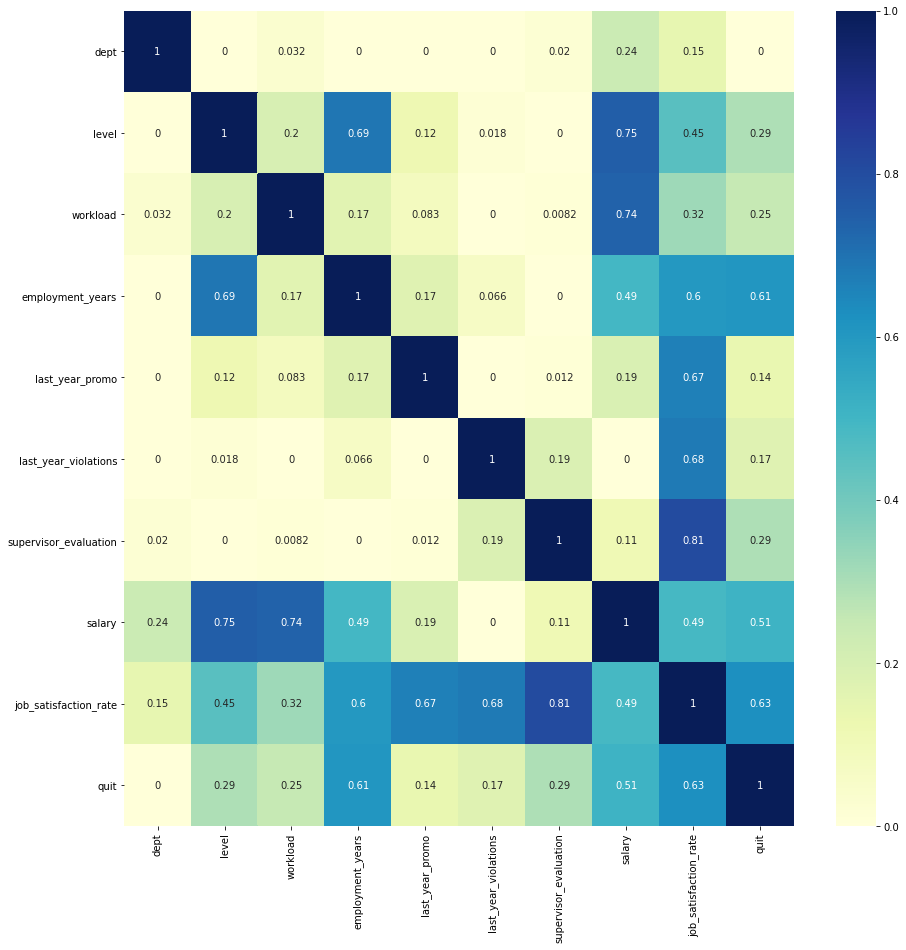

In [43]:
# Посмотрим матрицу корреляции
phik_corr_matrix = phik_matrix(merged)
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

Очевидно, что целевой признак quit имеет наиболее сильную связь с целевым признаком job_satisfaction_rate, далее по важности идут employment_years и salary.

### Подготовка данных

In [44]:
y_test=merged['quit']
X_test=merged.drop('quit',axis=1)
y_train=train_df['quit']
X_train=train_df.drop('quit',axis=1)

In [45]:
# добавим признак job_satisfaction_rate, предсказанный лучшей моделью из первой задачи
y_pred=best_model.predict(X_train)
y_pred=pd.DataFrame(y_pred, index=X_train.index, columns=['job_satisfaction_rate'])
X_train=X_train.merge(y_pred,left_index=True, right_index=True)

In [46]:
# создаём списки с названиями признаков
ohe_columns = [ 'dept', 'last_year_promo', 'last_year_violations' ]
ord_columns = ['level', 'workload', ]
num_columns = ['employment_years','supervisor_evaluation', 'salary', 'job_satisfaction_rate' ]
RANDOM_STATE = 42

In [47]:
# Создадим пайплайн с заполнением пропусков, масштабированием, кодированием и моделированием

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [  
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer 
ord_pipe = Pipeline(
    [   (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
                            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# cоздаём пайплайн для подготовки количественных признаков
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
#    ('log_transform', FunctionTransformer(log_transform)),
 #   ('poly', PolynomialFeatures(degree=4)),
    ('scaler', 'passthrough')  # 'passthrough' означает, что масштабировщик будет выбран позже
])

In [48]:
# Объединяем кодирование и масштабирование в один пайплан
preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
) 

In [49]:
# Создадим итоговый пайплайн, который соединит в себе обработку данных и моедлирование
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)
# словарь с гиперпараметрами для каждой модели
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors':range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            penalty='l1',
            solver='liblinear',
     
        )],
        'models__C': range(1,7),
#        'models__solver': ['liblinear', 'saga' ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,probability=True
     
        )],
        'models__C': range(1,3),
        'models__kernel': ['rbf', 'linear','poly', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid_search = RandomizedSearchCV (
    pipe_final, 
    param_grid, 
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_
best_params=grid_search.best_params_

# обучим лучшую модель
best_model.fit(X_train, y_train)

print('Лучшие модель и гиперпараметры:\n\n', best_params)
print ('Метрика roc-auc лучшей модели на тренировочной выборке:', grid_search.best_score_)


Лучшие модель и гиперпараметры:

 {'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__C': 1, 'models': SVC(C=1, kernel='poly', probability=True, random_state=42)}
Метрика roc-auc лучшей модели на тренировочной выборке: 0.9250956711931104


In [50]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred=best_model.predict(X_test)
y_pred_probability=best_model.predict_proba(X_test)[:,1]
print('Метрика roc-auc:', roc_auc_score(y_test, y_pred_probability))

Метрика roc-auc: 0.916069064975602


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


На тестовой выборке получился хороший результат метрики roc-auc. Лучшая модель оказалась svc с параметрами {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__C': 1, 'models': SVC(C=1, probability=True, random_state=42)}. Модель svc достаточно гидкая и умеет хорошо обходить шумы и аномалии, она гибче, чем логистичекая регрессия. В данных есть хорошая связь целевого признака с другими признаками, надо использовать это, а с линейной связью как раз хорошо работают логичтисекая регрессия и svc, но никак не к ближайших соседей и дерево решений.

## Выводы:
В процессе реализации проекта были достигнуты 2 цели: 
1) найдена лучшая модель для прогнозирования уровня удовлетворенности сотрудников:DecisionTreeRegressor с параметрами {'models__max_depth': 9, 'models__min_samples_leaf': 3, 'models__min_samples_split': 6, 'preprocessor__num': RobustScaler()}.
2) найдена лучшая модель для классификации - прогнозирования уйдет ли сотрудник либо останется: {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__C': 1, 'models': SVC(C=1, probability=True, random_state=42)}.

Для попытки улучшения качества модели была протестирована полиномизация и лог трансформация, но успешных результатов не было получено, лучшие модели были найдены с помощью подбора лучших гиперпараметров.
Портрет уволившегося сотрудника:
- Вероятно он из отдело продаж или технологического
- Вероятно он junior
- Вероятно загрузка у него была либо средняя или низкая
- Вероятно он совсем недолго проработал в компании
- В прошлом году у него явно не было повышения
- В прошлом году за ним явно числятся нарушения
- Он имеет среднюю оценку от руководителя
- Зарплата в среднем до 30 000.
Я бы предложила владельцу компании провести проверку в отделах продаж и технологическом, для того, чтобы выяснить причины, почему сотрудники ухдят, а также же руководителям отделов регулярно проводить личные встречи с сотрудниками, чтобы  как можно скорее понять, что сотрудник не справляется и возможно ему нужно как-то помочь, направить.